<a href="https://colab.research.google.com/github/jekams/activity01-course-tools/blob/main/Copy_of_CIS678_project_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


**Jesse Maina**

**A recommender system for Citizen birds that are likely to be observed next by scientist once given a checklist*
* eBird is a world dataset for birds recorded by various citizens in different places of the world.  this data contains over 100 million birds recored by nearly 750,000 citizen scientists across the globe.**


### Getting the Train data from csv file and performing log-transformation
In this first step we import the csv file containing the train data then perform log transformation on the samples.

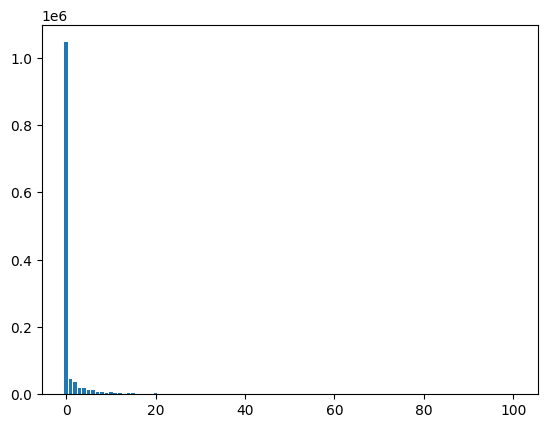

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
train_set = pd.read_csv("/content/sample_data/training_set.csv",index_col=0)

unique_values,counts = np.unique(train_set,return_counts=True)
plt.bar(unique_values,counts);

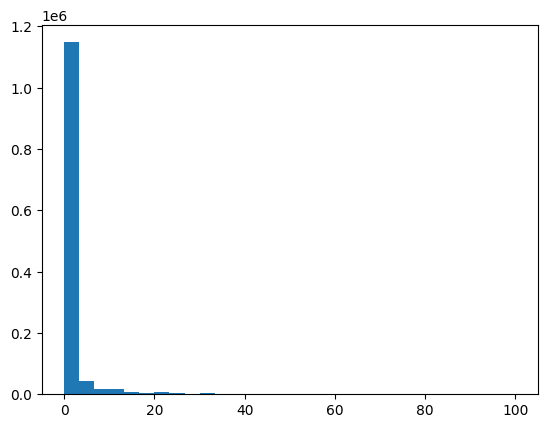

In [ ]:
plt.hist(pd.Series(train_set.values.flatten()),bins=30);

In [ ]:
train_set=np.log(1 +train_set) # performing log transformation
train_set.head()
train_set.shape

(85, 14832)

In [ ]:
pd.set_option('display.max_colwidth', 3)

species,checkpoints = train_set.shape #get shape of data
np.random.seed(2023) #use random seed for reproducibility
indices = np.random.choice(checkpoints,1000,replace=False)#pick random indices of your desired test sample size in this case 1000

print(indices)

### Generating a test set from the train data
Next we get a sample test set generated from the training data. Function `get_simulated_test_set()` takes a data argument and simulates a test set from a random sample of size 1000 obtained from the training set.

In [ ]:
def get_simulated_test_set(data,seed=42,**kwargs):
  np.random.seed(seed)
  test_labels = []
  def helper_function(sample):
    sample = sample.copy()#pass by value to avoid side effects of modifying sample
    non_zero_indices =np.where(sample!=0)[0]#find all indices that are non-zero
    if len(non_zero_indices)<5:
      label_indices = non_zero_indices#if non-zero indices are less than 5, pick them all
    else:
      label_indices = np.random.choice(non_zero_indices,5,replace=False) #otherwise choose five random non-zero indices
    sample[label_indices] = 0
    test_labels.append(label_indices)
    return sample

  results = data.apply(helper_function).T
  results["labels"] = test_labels
  return results

simulated_test_set = get_simulated_test_set(train_set.iloc[:,indices])
simulated_test_set.head(3)
simulated_test_set.shape


(1000, 86)

In [ ]:
partial_train_set_matrix = train_set.iloc[:,[i for i in range(checkpoints) if i not in indices]].to_numpy().T


## Fit a kmeans model
Next we fit the training data to a kmeans model and evaluate the top 5 using the centroids.



In [ ]:
class Naive_Kmeans():
  def __init__(self,cluster_centers=None,cluster_labels=None,**kwargs):
    #initialize labels and cluster centers
    self.__cluster_centers = cluster_centers
    self.__cluster_labels = cluster_labels

  def fit(self, train_data,K=11,tolerance=1e-10,max_iter=1000,seed=42,verbose=0):
    self.__cluster_centers, self.__cluster_labels  = None, None # reinitialize variables with every call to fit()
    self.train_data = train_data
    np.random.seed(seed)
    indexes = np.random.choice(checkpoints, K,replace=False)
    self.cluster_centers = train_data[indexes]#forgy method to initialize clusters

    for i in range(max_iter):

      distances = np.sum((train_data[:, np.newaxis]-self.cluster_centers)**2,axis=2)**.5
      self.cluster_labels = np.argmin(distances, axis=1)
      new_centers = np.array([np.mean(train_data[i==self.cluster_labels],axis=0) for i in range(K)])

      #criterion to check convergence in numpy sourced from chatGPT
      has_converged = np.all(np.abs(self.cluster_centers - new_centers) < tolerance)

      if verbose:
        print(f"Iteration number {i},Convergence attained: {has_converged}\n")

      if has_converged:
        break

      self.cluster_centers = new_centers

  @property
  def get_centroids(self):
    return self.cluster_centers

  @property
  def get_cluster_labels(self):
    return self.cluster_labels

  def recommend_top_5(self,sample):

    sample = sample.to_numpy()
    distances = (np.sum((sample - self.cluster_centers)**2,axis=1))**.5
    closest_centroid = self.cluster_centers[np.argmin(distances)].copy()

    closest_centroid[sample!=0] = 0.
    top_5 = np.argsort(closest_centroid)[::-1][:5]
    recommendation = np.zeros(species)
    recommendation[top_5] = 1
    return recommendation.astype(int)


In [ ]:
kmeans_instance = Naive_Kmeans()
kmeans_instance.fit(partial_train_set_matrix)

### Dimensionality reduction using PCA
We reduce the 85 feature variables to 2 components and visualize the assignment of clusters on a scatter plot.

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
vals = pca.fit_transform(partial_train_set_matrix.T)

In [ ]:
pca.explained_variance_ratio_ # first two components explain 33% and 13% variation respectively

array([0.33718189, 0.13062897])

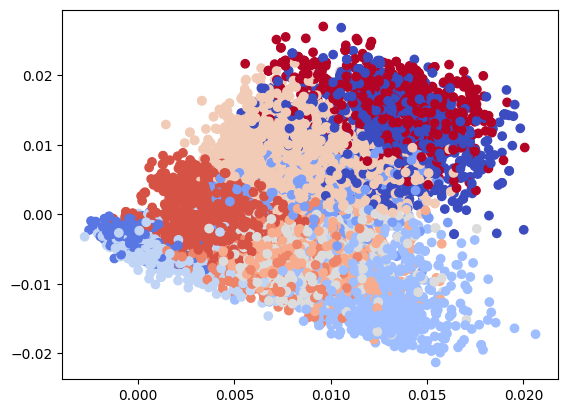

In [ ]:
plt.scatter(x = pca.components_[0], y = pca.components_[1], c=kmeans_instance.get_cluster_labels, cmap="coolwarm");

In [ ]:
def get_error_rate(simulated_predictions,ground_truth_labels):
  error_rate = []
  for i,sample in enumerate(simulated_predictions):
    error_rate.append(len(set(sample).difference(ground_truth_labels[i]))*2/85)
  return np.mean(error_rate)

In [ ]:
kmeans_simulated_predictions = simulated_test_set.iloc[:,:85].apply(kmeans_instance.recommend_top_5,axis=1).apply(lambda x: np.where(x==1)[0])

print(f"Simulated error rate for kmeans with {len(kmeans_instance.cluster_centers)} clusters: \
{get_error_rate(kmeans_simulated_predictions,simulated_test_set.iloc[:,85]):.4f}")


Simulated error rate for kmeans with 11 clusters: 0.0593


### Import and normalize the test set data
Next we get the test data and perform log transformation.

In [ ]:
test_set = pd.read_csv("/content/sample_data/My_CIS 678 LABS/test_set.csv", index_col=0)
test_set = np.log(1+test_set)
test_set.head(3)


,test1,test2,test3,test4,test6,test7,test8,test9,test10,test11,...,test6348,test6349,test6350,test6351,test6352,test6353,test6354,test6355,test6356,test6357
Apapane,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hawaii_Elepaio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Kalij_Pheasant,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Next we import the sample submission file to write our predictions

In [ ]:
sample_submission = pd.read_csv("/content/sample_data/My_CIS 678 LABS/submission_ids.csv", index_col=0)
sample_submission.head(3)

,Id,row_name,col_name
1,row_1,Apapane,test1
2,row_2,Hawaii_Elepaio,test1
3,row_3,Kalij_Pheasant,test1


### Create a KNN model
We now create a knn model in a Minkowski space, then we adjust values to include Euclidean and Manhattan distances as well as the weighted versions. For checkpoints that had less than 5 non-zero values, (which means all the non-zero values will be used as labels in the test), we will have a vector filled with zero. To avoid zero division error, we impute a small number epsilon, $\epsilon=10^{-16}$

In [ ]:
class Naive_Knn():
  def __init__(self):
   pass

  def fit(self,train_data,test_data,k=10,strategy="simple",method="Euclidean",verbose=0):
    if method == "Manhattan" or method=="Euclidean" or method=="Minkowski":
      if method == "Manhattan":
        if verbose:
          print(f"Calculating {strategy} {method}...")
        p = 1
      elif method == "Euclidean":
        if verbose:
          print(f"Calculating {strategy} {method}...")
        p = 2
      else:
        if verbose:
          print(f"Calculating {strategy} {method}...")
        p = 85
      return test_data.apply(self.nearest_neighbors_recommend_euclidean,axis=1,args=(train_data,k,p,strategy))

    elif method=="Cosine":
      if verbose:
        print(f"Calculating {strategy} {method}...")
      return test_data.apply(self.nearest_neighbors_recommend_cosine,axis=1,args=(train_data,k,strategy))

  def nearest_neighbors_recommend_euclidean(self,sample,train_data,k,p,strategy):
    sample = sample.to_numpy()
    if strategy=="simple":
      distances = (np.sum((np.abs(train_data - sample))**p,axis=1))**(1/p)
    else:
      non_zero_samples = sample!=0
      weight = (np.sum(~non_zero_samples)-5)/np.sum(~non_zero_samples)
      distances_1 = np.sum((np.abs(train_data[:,non_zero_samples]-sample[non_zero_samples]))**p,axis=1)
      distances_2 = np.sum(weight * np.abs((train_data[:,~non_zero_samples]-sample[~non_zero_samples]))**p,axis=1)
      distances = (distances_1 + distances_2)**(1/p)

    indices = np.argsort(distances)
    avg_distance = np.mean(train_data[indices[:k]], axis=0)
    avg_distance[sample!=0] = 0
    top_5 = np.argsort(avg_distance)[::-1][:5]
    recommendations = np.zeros(species)
    recommendations[top_5] = 1
    return recommendations.astype(int)

  def nearest_neighbors_recommend_cosine(self,sample,train_data,k,strategy):
    sample = sample.to_numpy().copy()#pass by value/avoid ovewriting the original test set when setting values to epsilon
    if np.all(sample==0):
        sample = np.ones(len(sample)) * 10e-16
    if strategy=="simple":
      distances = (np.dot(train_data,sample))/(np.sqrt(np.sum(train_data**2,axis=1)*np.sum(sample**2)))
    else:
      non_zero_samples = sample!=0
      weight = (np.sum(~non_zero_samples)-5)/(np.sum(~non_zero_samples)+1)
      distances = (np.dot(train_data+weight**20,sample))/(np.sqrt(np.sum(train_data**2,axis=1)*np.sum(sample**2)))

    indices = np.argsort(distances)[::-1]
    avg_distance = np.mean(train_data[indices[:k]], axis=0)
    avg_distance[sample!=0] = 0
    top_5 = np.argsort(avg_distance)[::-1][:5]
    recommendation = np.zeros(species)
    recommendation[top_5] = 1
    return recommendation.astype(int)

### Evaluating KNN
We now evaluate the various `KNN` methods and compute their respective error rates

In [ ]:
knn_instance = Naive_Knn()
knn_performance  = dict()

def printResults(train_set,test_set,k=10,strategy="simple",method="Euclidean",verbose=0):
  simulated_predictions = knn_instance.fit(train_set,test_set,k,strategy,method,verbose)\
  .apply(lambda x: np.where(x==1)[0])
  error = get_error_rate(simulated_predictions,simulated_test_set.iloc[:,85])
  print(f"{method} {strategy} KNN error rate {error:.4f}\n")
  knn_performance[f"{method[:3]} {strategy[:3]}"] = error


printResults(partial_train_set_matrix,simulated_test_set.iloc[:,:85],method="Manhattan",strategy="simple",verbose=1)
printResults(partial_train_set_matrix,simulated_test_set.iloc[:,:85],method="Manhattan",strategy="weighted",verbose=1)
printResults(partial_train_set_matrix,simulated_test_set.iloc[:,:85],method="Cosine",strategy="simple",verbose=1)
printResults(partial_train_set_matrix,simulated_test_set.iloc[:,:85],method="Cosine",strategy="weighted",verbose=1)
printResults(partial_train_set_matrix,simulated_test_set.iloc[:,:85],verbose=1)
printResults(partial_train_set_matrix,simulated_test_set.iloc[:,:85],strategy="weighted",verbose=1)
printResults(partial_train_set_matrix,simulated_test_set.iloc[:,:85],method="Minkowski",strategy="weighted",verbose=1)




Calculating simple Manhattan...
Manhattan simple KNN error rate 0.0477

Calculating weighted Manhattan...
Manhattan weighted KNN error rate 0.0471

Calculating simple Cosine...
Cosine simple KNN error rate 0.0479

Calculating weighted Cosine...
Cosine weighted KNN error rate 0.0496

Calculating simple Euclidean...
Euclidean simple KNN error rate 0.0505

Calculating weighted Euclidean...
Euclidean weighted KNN error rate 0.0500

Calculating weighted Minkowski...
Minkowski weighted KNN error rate 0.0549



Compare error-rates of different KNN distance metrics

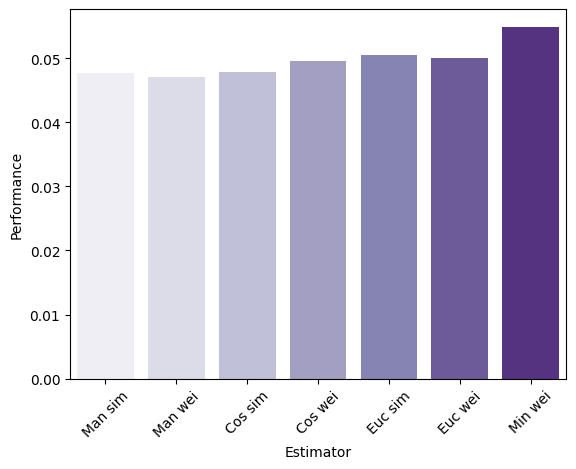

In [ ]:
import seaborn as sns

sns.barplot(x=list(knn_performance.keys()), y=list(knn_performance.values()), palette="Purples")
plt.xlabel("Estimator")
plt.ylabel("Performance")

plt.xticks(rotation=45);


### Generating a copy of test set
We can create a copy of the whole test data and validate against folds of train data. We can create a Spark instance or use batch processing to create a `test_set_copy` to avoid memory overload.

In [ ]:
from math import ceil
batches = []
BATCH_SIZE = ceil(checkpoints/32)

for i in range(BATCH_SIZE):
  batches.append(get_simulated_test_set(train_set.iloc[:,i*32:(i+1)*32]))

test_set_copy = pd.concat(batches)
test_set_copy.head(3)



,Apapane,Hawaii_Elepaio,Kalij_Pheasant,Northern_Cardinal,Omao,Warbling_White_eye,Black_necked_Stilt,Cattle_Egret,Hawaii_Amakihi,House_Finch,...,Least_Tern,Wild_Turkey,Black_Francolin,Eurasian_Wigeon,Greater_White_fronted_Goose,Mourning_Dove,Pectoral_Sandpiper,White_faced_Ibis,Red_masked_Parakeet,labels
train1,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,2.397895,0.0,1.609438,...,1.386294,0.0,0.0,0.0,0.0,0.0,0.0,1.386294,0.0,"[3, 11, 38, 6, 21]"
train2,0.0,0.0,0.0,0.0,0.0,0.693147,0.000000,0.693147,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"[43, 12, 46, 44, 62]"
train3,0.0,0.0,0.0,0.0,0.0,0.000000,3.583519,0.693147,0.0,0.693147,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,"[10, 55, 5, 13, 3]"


### Cross Validation with 5-folds
We pick Manhattan and Cosine and perform cross validation to determine the optimal value for hyperparameter k.

In [ ]:
%timeit

def cross_validate(train_set,test_set,n_folds=5,k_values=range(1,92,10),method="Euclidean",strategy="simple",verbose=0):

  fold_errors = []# create list to append the errors for each fold for a given value of k
  k_errors = dict() #a dictionary to hold the errors for values of k
  for k in k_values:
    start_index=0
    increment = checkpoints//n_folds # integer division to get the increment value for each loop
    for i in range(n_folds):


      cv_partial_train_set = pd.concat((train_set.iloc[:,:start_index],train_set.iloc[:,start_index+increment:]),axis=1)

      cv_test_set=test_set_copy.iloc[start_index:start_index+increment,:]
      cv_predictions = knn_instance.fit(cv_partial_train_set.to_numpy().T,cv_test_set.iloc[:,:85],k=k,method=method,strategy=strategy,verbose=verbose)\
      .apply(lambda x: np.where(x==1)[0])
      fold_errors.append(np.mean(get_error_rate(cv_predictions,cv_test_set.iloc[:,85])))
      start_index+=increment
    k_errors[k] = np.mean(fold_errors)

  return k_errors

k_errors_manhattan= cross_validate(train_set=train_set, test_set=test_set_copy,method="Manhattan",strategy="weighted",verbose=0)
k_errors_cosine = cross_validate(train_set=train_set, test_set=test_set_copy,method="Cosine",verbose=0)

Text(0.5, 1.0, 'Error curve for different values of k')

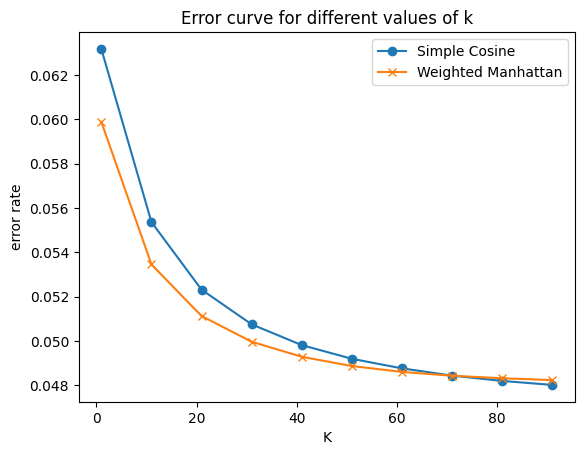

In [ ]:
plt.plot(k_errors_cosine.keys(),k_errors_cosine.values(),marker="o",label="Simple Cosine")
plt.plot(k_errors_manhattan.keys(),k_errors_manhattan.values(),marker="x",label="Weighted Manhattan")
plt.legend()
plt.xlabel("K")
plt.ylabel("error rate");
plt.title("Error curve for different values of k")

### Give recommendations on the whole data set with the optimal value of K
We apply KNN using the Cosine similarity to predict the top 5 values on each checkpoint. We chose 45 as our value for hyperparameter k because it gave the lowest error on cross validation.

In [ ]:
predictions = test_set.apply(knn_instance.nearest_neighbors_recommend_cosine,args=(train_set.to_numpy().T,45,"simple"))

In [ ]:
predictions_flat = predictions.T.values.flatten()
np.all(predictions.sum()==5)

True

In [ ]:
sample_submission["Expected"] = predictions_flat
sample_submission.head(3)
sum(sample_submission["Expected"])


,Id,row_name,col_name,Expected
1,row_1,Apapane,test1,0
2,row_2,Hawaii_Elepaio,test1,0
3,row_3,Kalij_Pheasant,test1,0


In [ ]:
sample_submission.to_csv("submission.csv", index=False)